# Perplexity ratio score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of perplexity ratio (PR) scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler divergence (KLD) score. See the figure below from the [Wikipedia article on KLD](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

Workflow is as follows:
1. Get kernel density estimate of PR score distributions for human and synthetic text fragments in the training data.
2. Calculated the KLD between the human and synthetic PR score distributions.
3. Get a get kernel density estimate of the KLD.
4. Use the probability density function from the KLD kernel density estimate to calculate a KLD score for each text fragment in the training and testing data.
5. Add the KLD score as a new feature.

The above will be done individually for each fragment length bin and the combined data. This way the KLD score feature in each bin will capture the PR score distribution for text fragments in that specific length regime, rather that for the whole dataset.

One additional note - after some initial testing - the 4th step above is very slow due to the sheer number of points that need to be evaluated. Therefore, the workflow will be split up as follows to more efficiently utilize compute resources.

**Version 2 workflow:**

**Part I**: parallelized over the length bins.

1. Get kernel density estimate of score distributions for human and synthetic text fragments from the training data.
2. Calculate the KLD between the human and synthetic score distributions.
3. Get a kernel density estimate of the KLD.
4. Serialize the KLD's kernel density estimate to disk.

**Park II**: Parallelized over evaluation points in each bin, bins processed serially.

5. Load KLD kernel density estimate.
6. Calculate KDE value for each score in bin.
7. Add scores as new feature in bin dataset.


In [1]:
from IPython.display import Image
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

## 1. Run set-up

In [2]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Do the imports
import configuration as config
import functions.kullback_leibler_divergence as kld_funcs

Working directory: /mnt/arkk/llm_detector/classifier


In [3]:
# The dataset we want to bin - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Feature name
input_feature_name = 'Perplexity ratio score'

## 2. Get Kullback-Leibler divergence kernel density estimates

In [4]:
%%time

# Run part I of the workflow in parallel over the bins - gets kernel density estimate
# of Kullback-Leibler divergence between the feature's distribution for human and
# synthetic text fragments in the training data, saves to disk for later use.

kld_funcs.get_kullback_leibler_kdes(
    feature_name = input_feature_name,
    hdf5_file = input_file,
    logfile_name = 'perplexity_ratio_KLD_KDE.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/perplexity_ratio_KLD_KDE.log

bin_001_050 finished: True
bin_026_075 finished: True
bin_051_100 finished: True
bin_076_125 finished: True
bin_101_150 finished: True
bin_126_175 finished: True
bin_151_200 finished: True
bin_176_225 finished: True
bin_201_250 finished: True
bin_226_275 finished: True
bin_251_300 finished: True
combined finished: True
CPU times: user 424 ms, sys: 424 ms, total: 848 ms
Wall time: 2.01 s


## 3. Evaluate perplexity ratio scores and add KLD feature

In [5]:
%%time

# Run part II of the workflow described above - uses previously stored
# kernel density estimates of the Kullback-Leibler divergence between
# the perplexity ratio scores for human and synthetic text fragments
# in each bin. Loads the data from each bin sequentially and evaluates
# each text fragment's perplexity ratio score. Parallelizes evaluation
# over data in the bin. Adds result back to hdf5 as new feature column.

kld_funcs.make_kullback_leibler_feature(
    feature_name = input_feature_name,
    hdf5_file = input_file,
    logfile_name = 'perplexity_ratio_KLD_feature_addition.log'
)

Will log to: /mnt/arkk/llm_detector/classifier/logs/perplexity_ratio_KLD_feature_addition.log

bin_001_050 finished: True
bin_026_075 finished: True
bin_051_100 finished: True
bin_076_125 finished: True
bin_101_150 finished: True
bin_126_175 finished: True
bin_151_200 finished: True
bin_176_225 finished: True
bin_201_250 finished: True
bin_226_275 finished: True
bin_251_300 finished: True
combined finished: True
CPU times: user 8.76 s, sys: 12.7 s, total: 21.5 s
Wall time: 1min 8s


## 4. Sanity check results

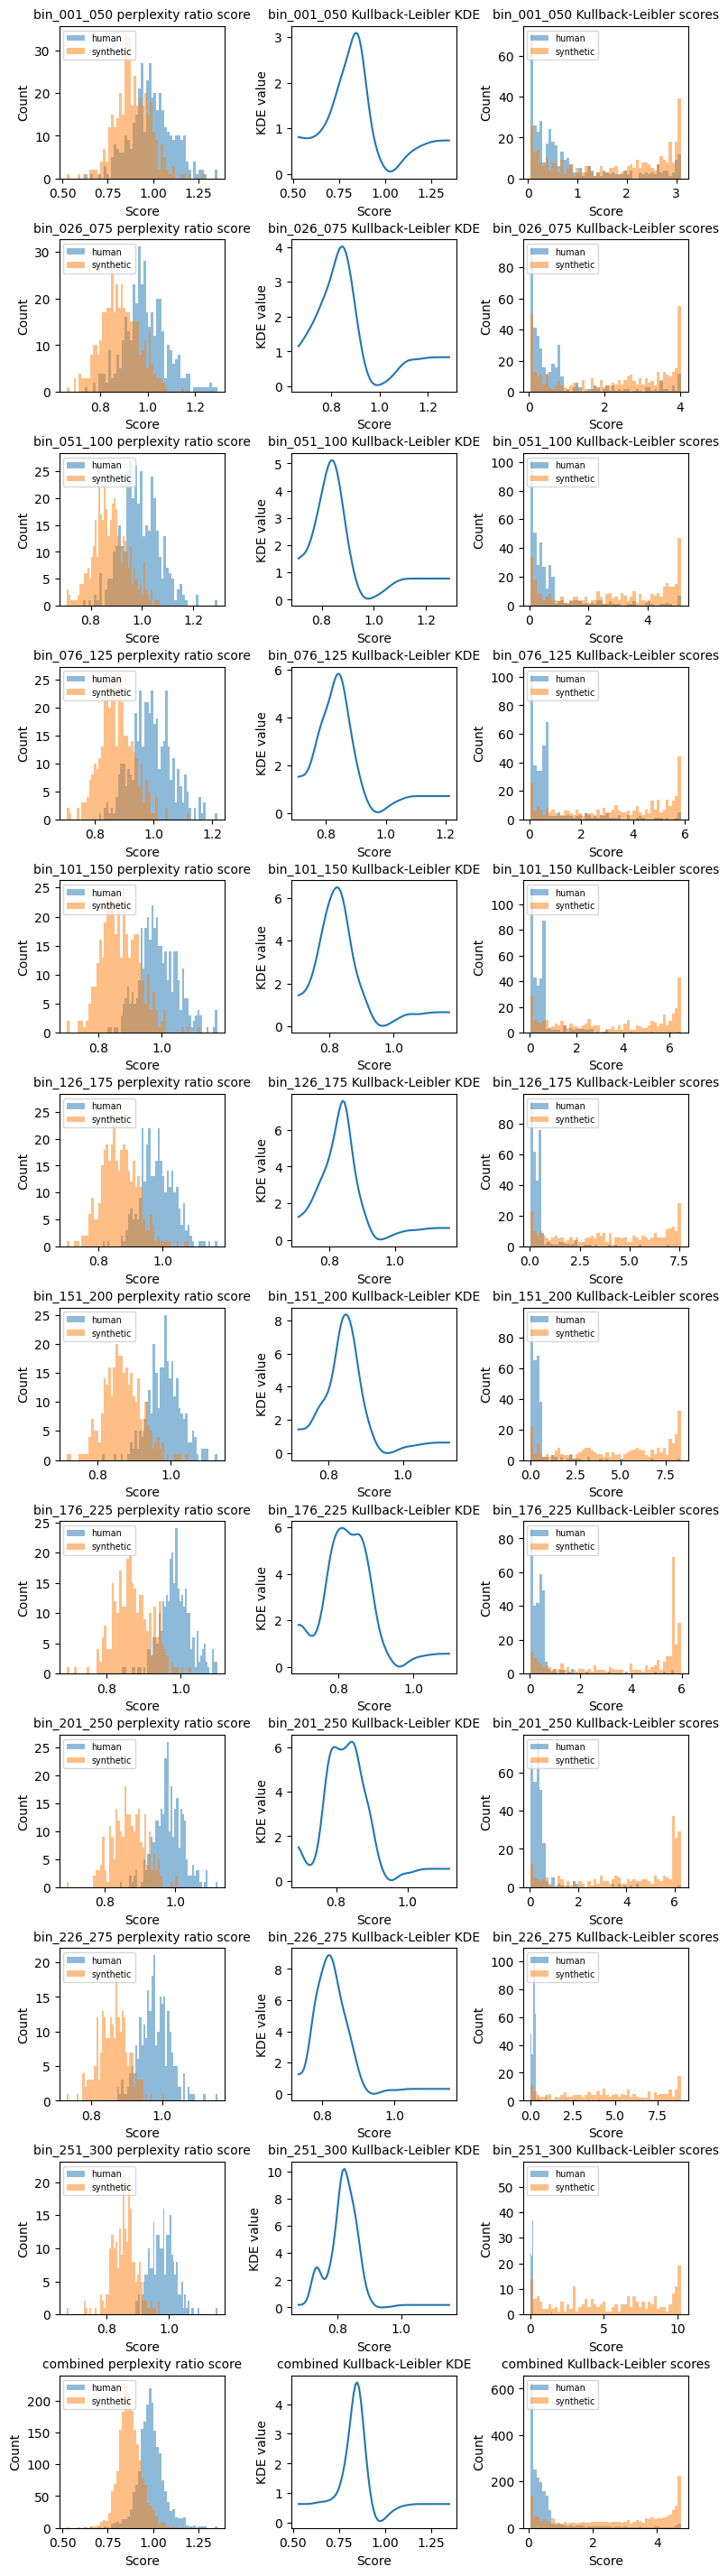

In [6]:
kld_funcs.plot_results(
    hdf5_file = input_file, 
    feature_name = input_feature_name
).show()